## Import necessary libs

In [1]:
# deeper cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import h5py

## Load train and test dataset + scale all the Data

*  **load the images and reshape** the data arrays to have a single color channel.
*  **one hot encoding**:
    *  use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes.
*  **normalize the pixel values**:  
    *  the pixel values for each image in the dataset are in the range between black and white, or 0 and 255, so we need to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.


In [2]:
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [3]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

## Define Model

#### The Front-End (Feature Extractor):  


  
  
   *  starting with a single **convolutional layer**  
   
       * with a small ***filter size (3,3)** and a modest number of nodes(filters) ***(32)***
       * filter size of **3 by 3** because we have an **image size == 28 by 28 <<< 128 by 128** so we **HAVE TO USE** a filter size of **1 by 1 of 3 by 3** , if the image size > 128 by 128 we use a bigger filter of 5 by 5 or 7 by 7 ...
       * a linear operation technique designed for two-dimensional input (images), involves the multiplication of input data and a 2-dimensional array of weights, called a ***filter or a kernel***.
       * the filter is ***designed to detect a specific type of feature*** in the input.
       * the result is a two-dimensional array of output values that represent a filtering of the input that maps the detected features in what we call a ***“feature map“***
       * ***Multiple Filters*** <==> learning multiple features in parallel for a given input.
       * it is common for a conv layer to learn from 32 to 512 filters in parallel.
       * ***Multiple Layers*** <==> The stacking of conv layers allows a hierarchical decomposition of the input
       * ***A limitation of the feature map*** output of convolutional layers is that they record the precise position of features in the input. This means that small movements in the position of the feature in the input image will result in a different feature map.
         
         
   *  followed by a **max pooling layer**
       *  must be added **after the conv layer**
       *  operates on each feature map separately to **create a new set** of the same number of pooled feature maps
       *  much like a filter to be applied to feature maps, ***almost always 2×2*** pixels applied with a stride of 2 pixels, and will always reduce the size of each feature map by a factor of pool size
       *  there are ***Average Pooling , Max Pooling and Global Pooling Layers*** depending on the modeling context of your problem  
         
         
   *  then be **flattened** to provide features to the classifier.  
     
     


####  The Back-End (Classifer):  
  


  
   *  ***multi-class classification task***
       *  require an **output layer with 10 nodes** in order to predict the probability distribution of an image belonging to each of the 10 classes.
       *  require the use of a ***softmax activation function*** (probability function)
       *  we can add a ***100 nodes dense layer*** to interpret the features.
       *  All layers will use the ***ReLU activation function*** and the He weight initialization scheme for the simple reason is that we have the input data in image formats which means ***all values of the image matrix will be from 0 to 255**, and to avoid problems that can accures after conv layer or pooling we will be ***replacing all negative values with 0 and keep all the remaining values as they are***.


#### Optimization :

* stochastic gradient descent optimizer
      *  an optimization algorithm 
      *  The job of the algorithm is to find a set of internal model parameters that perform well against some performance measure such as logarithmic loss or mean squared error.
* learning rate of 0.01
* a momentum of 0.9
* **kernel_initializer** : used for initializing the kernel weights matrix. The weight matrix is a matrix of weights that are multiplied with the input to extract relevant feature kernels.
* **dense layer** : also referred to as a **fully connected layer** is a layer that is **used in the final stages of the neural network**. This layer helps in changing the dimensionality of the output from the preceding layer so that **the model can easily define the relationship between the values of the data** in which the model is working.
* and "categorical cross-entropy" for the  loss function
* to accelerate the learning of a model : ***Batch normalization*** after convolutional and fully connected layers, designed to automatically standardize the inputs to a layer and has the effect of **dramatically accelerating the training process** of a neural network, the layer will keep track of statistics for each input variable and use them to standardize the data.
* **Increase in Model Depth**: following a **VGG-like pattern** of adding more convolutional and pooling layers with the same sized filter as it is very effective at **extracting features from images.** So we will **add a double convolutional layer** with 64 filters each, followed by **another max pooling layer**.

#### Note:  
The **number of layers** in a model is referred to as its **depth**.  

The **number of nodes** in a layer is referred to as the **width**.

In [4]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Evaluate Model

*  model will be evaluated using **5-fold cross-validation**:  
   *  5 refers to the number of groups that a given data sample is to be split into.
   *  a popular method because and generally results in a less biased or less optimistic estimate of the model skill than other methods
   *  ***Shuffle*** the dataset randomly.
   *  ***Split*** the dataset into ***5 groups***
   *  For each unique group:
      *  Take the group as a hold out or test data set
      *  Take the remaining groups as a training data set
      *  Fit a model on the training set and evaluate it on the test set
      *  Retain the evaluation score and discard the model
   *  Summarize the skill of the model using the sample of model evaluation scores
   *  The value of **5** was chosen to provide a baseline for both repeated evaluation and to not take long running time.
   *  a **batch size of 32** 
         *  a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
   *  **number of epochs = 10** 
         *  a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.
         
**Summary**:  

Assume we have a dataset with ***60K samples*** (rows of data) and we choose a ***batch size of 32 and 10 epochs.***

This means that ***the dataset will be divided into 1875 batches***, each with ***32 samples***. The model weights will be updated after each batch of 32 samples.

This also means that ***one epoch will involve 1875 batches*** or 1875 ***updates to the model.***

With ***10 epochs***, the model will be exposed to or ***pass through the whole dataset 10 times***. That is a total of ***320 batches during the entire training process.***

In [9]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # data augmentation for more enhanced results -------------------------------------------------
        datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.45)
        datagen.fit(trainX)
        datagen.fit(testX)
        #------------- End Data augmentation ----------------------------------------------------------
        # fit model
        #history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=2)
        history = model.fit(datagen.flow(trainX, trainY, batch_size=32), epochs=10, validation_data=(datagen.flow(testX,testY)), verbose=2)
        #verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
        # save model
        model.save('final_Handwritten_digits_model.h5')
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

## Results Viz

*  the diagnostics of the **learning behavior of the model during training** + the **estimation of the model performance**:  
   *  creating a line plot showing model performance on the train and test set during each fold of the 5-fold cross-validation.
   *  one for loss and one for accuracy.
   *  **Blue lines** will indicate model performance on the **training** dataset
   *  **orange lines** will indicate performance on the **test** dataset.


In [10]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [11]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

## Testing

**this cell bellow** dedicated for testing  
when runing the cell it will take about **30mnit** to be done, and for that i turned it into mardkown cell to avoid long runs

Epoch 1/10
1500/1500 - 31s - loss: 0.3056 - accuracy: 0.9043 - val_loss: 0.1530 - val_accuracy: 0.9530
Epoch 2/10
1500/1500 - 36s - loss: 0.1490 - accuracy: 0.9532 - val_loss: 0.1120 - val_accuracy: 0.9662
Epoch 3/10
1500/1500 - 39s - loss: 0.1127 - accuracy: 0.9649 - val_loss: 0.1068 - val_accuracy: 0.9667
Epoch 4/10
1500/1500 - 37s - loss: 0.0982 - accuracy: 0.9690 - val_loss: 0.0927 - val_accuracy: 0.9718
Epoch 5/10
1500/1500 - 37s - loss: 0.0881 - accuracy: 0.9725 - val_loss: 0.0754 - val_accuracy: 0.9774
Epoch 6/10
1500/1500 - 37s - loss: 0.0841 - accuracy: 0.9738 - val_loss: 0.0715 - val_accuracy: 0.9793
Epoch 7/10
1500/1500 - 36s - loss: 0.0708 - accuracy: 0.9774 - val_loss: 0.0789 - val_accuracy: 0.9753
Epoch 8/10
1500/1500 - 36s - loss: 0.0743 - accuracy: 0.9769 - val_loss: 0.0684 - val_accuracy: 0.9791
Epoch 9/10
1500/1500 - 37s - loss: 0.0671 - accuracy: 0.9786 - val_loss: 0.0689 - val_accuracy: 0.9770
Epoch 10/10
1500/1500 - 37s - loss: 0.0669 - accuracy: 0.9788 - val_loss:

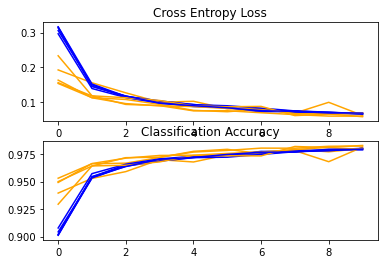

Accuracy: mean=98.867 std=0.184, n=5


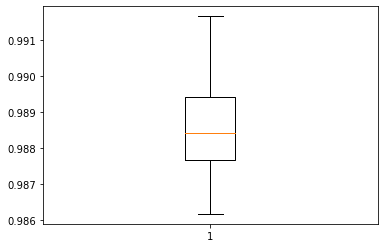

In [12]:
#run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

#entry point, run the test harness
run_test_harness()

with batchnormalization : Accuracy: mean=99.125 std=0.074, n=5

without batchnormalization : Accuracy: mean=99.018 std=0.120, n=5